# [Sutton and Barto Notebooks](https://github.com/seungjaeryanlee/sutton-barto-notebooks): Figure 2.5

[모두AI](https://www.modu.ai)  
Author: Ryan Lee  
저자: 이승재  

![Figure 2.5](figure_2_5.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def argmax_all(list_):
    """
    Returns all argmax of given list in a list. Different from np.argmax which
    returns first instance only.
    주어진 list의 최대값들의 index들을 list 형태로 반환합니다. 첫 최대값의 index만 반환하는
    np.argmax와는 다릅니다.
    """
    return np.argwhere(list_ == list_.max()).flatten()

## Environment

![Figure 2.1](figure_2_1.png)

In [3]:
class Environment:
    """
    A variant of the 10-armed Testbed environment shown in Figure 2.1. The
    means of rewards are now choosed from a distribution with mean 4
    instead of 0 now.
    Figure 2.1에서 보여진 10개의 행동이 가능한 Bandit의 변형입니다. 이제 보상 분포의
    기대값들은 평균 0이 아니라 평균 4의 분포에서 고릅니다.
    """
    def __init__(self, n_actions=10):
        self.action_space = [i for i in range(n_actions)]
        self.distributions = []
        for _ in range(n_actions):
            mean = np.random.normal(4, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

    def step(self, action):
        """
        Returns the reward of the given action.
        주어진 행동에 대한 보상을 반환합니다.
        """
        mean, stddev = self.distributions[action]
        reward = np.random.normal(loc=mean, scale=stddev)
        return reward

    def reset(self):
        """
        Reset the reward distributions of the environment.
        환경의 보상 분포들을 재설정합니다.
        """
        self.distributions = []
        for _ in range(len(self.action_space)):
            mean = np.random.normal(0, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

## Agent

In [4]:
class PreferenceAgent:
    """
    A prefernece-based agent.
    선호 기반 에이전트입니다.
    """
    def __init__(self, action_space, learning_rate=0.9, use_baseline=True):
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.h = np.zeros(len(action_space), dtype=float)
        self.action_count = 0
        
        if use_baseline:
            self.baseline = 0
            self.name = '$\\alpha$ = {} with baseline'.format(self.learning_rate)
        else:
            self.baseline = None
            self.name = '$\\alpha$ = {} without baseline'.format(self.learning_rate)


    def get_action_p(self):
        """
        Get probabilities of choosing each action.
        H값으로부터 행동을 고를 확률을 계산합니다.
        """
        e_h = np.exp(self.h)
        return e_h / np.sum(e_h)

    def get_action(self):
        """
        Choose action using preference.
        선호도를 고려하여 행동을 선택합니다.
        """
        return np.random.choice(self.action_space, p=self.get_action_p())

    def update(self, action, reward):
        """
        Update appropriate H value with given action and reward.
        주어진 행동과 보상으로 H값을 업데이트합니다.
        """
        action_p = self.get_action_p()

        if self.baseline is None:
            baseline = 0
        else:
            self.action_count += 1
            self.baseline += (reward - self.baseline) / self.action_count
            baseline = self.baseline

        for a in self.action_space:
            if action == a:
                self.h[a] += self.learning_rate * (reward - baseline) * (1 - action_p[a])
            else:
                self.h[a] += self.learning_rate * (reward - baseline) * action_p[a]

    def reset(self):
        """
        Reset agent's H values to 0.
        에이전트의 H값들을 0으로 재설정합니다.
        """
        self.h = np.zeros(len(self.action_space), dtype=float)

## Plots

In [5]:
def run(env, agent, n_steps=1000):
    """
    Take actions on the bandit environment. This is called a "run".
    Bandit 환경에서 n_steps 번 행동을 합니다. 이것을 하나의 '실행'이라 합니다.
    """
    actions = np.zeros(n_steps, dtype=int)
    for i in range(n_steps):
        actions[i] = agent.get_action()
        reward = env.step(actions[i])
        agent.update(actions[i], reward)

    return actions

In [6]:
def runs(env, agent, n_runs=2000, n_steps=1000):
    """
    Perform multiple runs on given environment and agent, resetting
    environment and agent after every run. Resetting environment
    changes the actions' reward distributions, and resetting the
    agent resets its Q values.
    주어진 환경과 에이전트로 여러 번 실행합니다. 각 실행마다 환경과 에이전트는
    초기화됩니다. 환경이 초기화되면 각 행동들의 보상 분포가 바뀌고, 에이전트가
    초기화되면 Q값이 초기화됩니다.
    """
    optimal_action_counts = np.zeros(n_steps)

    for i in range(n_runs):
        env.reset()
        agent.reset()
        actions = run(env, agent, n_steps)

        for step, action in enumerate(actions):
            if action == env.optimal_action:
                optimal_action_counts[step] += 1

    return optimal_action_counts / n_runs

In [7]:
def plot(agents, n_runs, n_steps):
    """
    Plot a graph of percentage that an optimal action is chosen throughout runs
    for agents specified by their epsilon values. Optimal action is the action
    with highest mean.
    실행들 동안 평균적으로 최적 행동을 얼마나 많이 하는지 나타내는 그래프를 그립니다. 최적 행동은
    가장 평균값이 높은 보상을 선택하는 것입니다.
    """

    names = []
    for agent in agents:
        names.append(agent.name)
        env = Environment()
        optimal_action_percent = runs(env, agent, n_runs, n_steps)
        plt.plot(optimal_action_percent)

    plt.legend(names)
    plt.xlabel('Steps')
    plt.xlim(0, n_steps)
    plt.xticks(np.arange(0, n_steps+1, 250))
    plt.ylabel('% Optimal Action', rotation='horizontal', ha='right')
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.2))
    # plt.savefig('plot.png')
    plt.show()

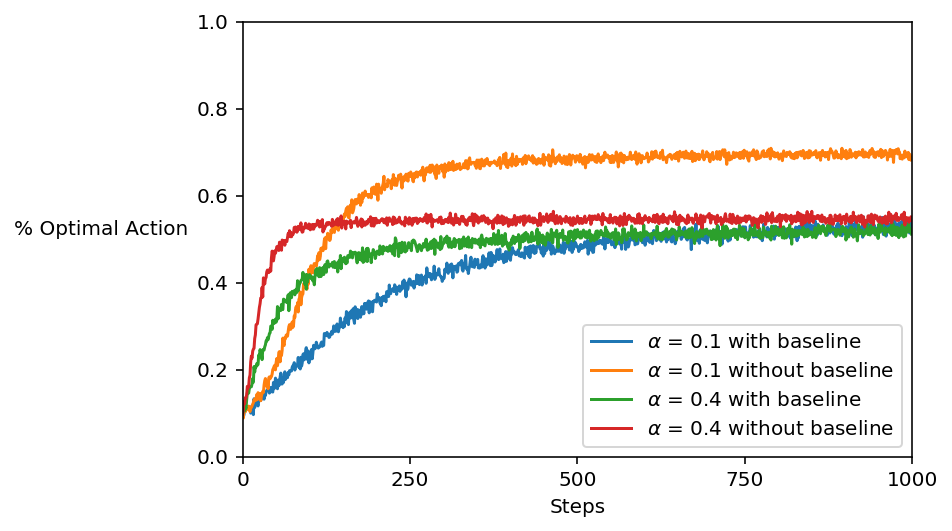

In [8]:
env = Environment()
agents = [
    PreferenceAgent(env.action_space, learning_rate=0.1, use_baseline=True),
    PreferenceAgent(env.action_space, learning_rate=0.1, use_baseline=False),
    PreferenceAgent(env.action_space, learning_rate=0.4, use_baseline=True),
    PreferenceAgent(env.action_space, learning_rate=0.4, use_baseline=False),
]
plot(agents, 2000, 1000)